<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_3_4_TSP_Operators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install DEAP
!pip install deap --quiet

In [ ]:
#@title Imports
import array
import random
import json
import time

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx
from IPython.display import clear_output 

In [ ]:
#@title Defining bounds for the Map { run: "auto" }
min_bounds = 0 #@param {type:"slider", min:0, max:100, step:1}
map_range = 100 #@param {type:"slider", min:0, max:200, step:1}
max_bounds = min_bounds + map_range
destinations = 15 #@param {type:"slider", min:5, max:30, step:1}

random.seed(222)
print(f"Map Bounds [{min_bounds},{max_bounds}]")

Map Bounds [0,100]


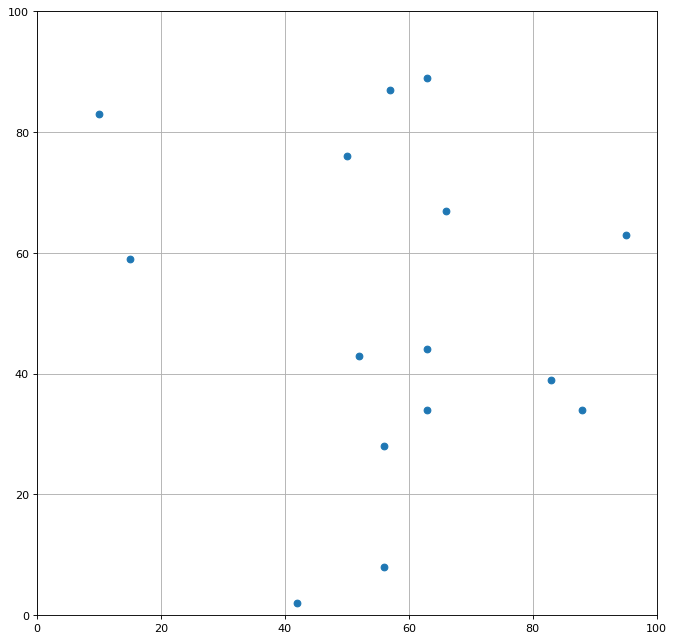

In [ ]:
#@title Plotting Random Individual on Map
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
map = np.random.randint(min_bounds,max_bounds, size=(destinations,2))

plt.scatter(map[:,0], map[:,1])
axes = plt.gca()
axes.set_xlim([min_bounds,max_bounds])
axes.set_ylim([min_bounds,max_bounds])
plt.grid()

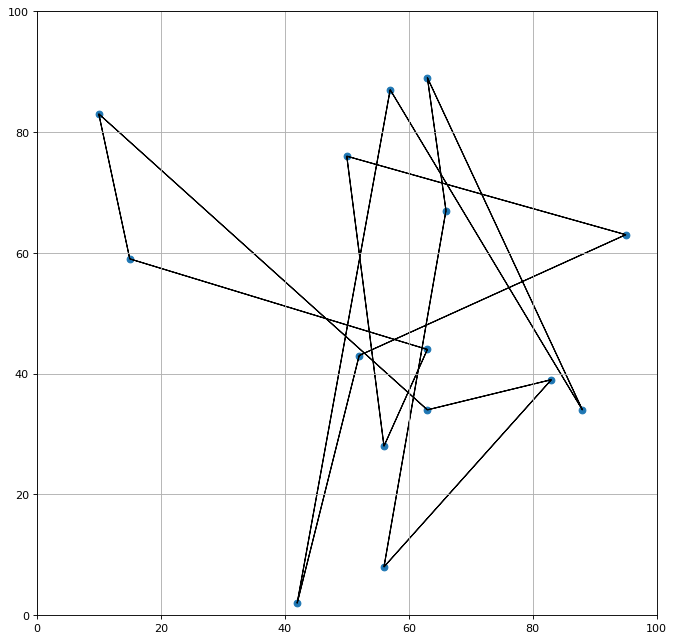

In [ ]:
#@title Show the Current Path
def linear_path(map):
  path = []
  for i,pt in enumerate(map):    
    path.append(i)
  return path

path = linear_path(map)

def draw_path(path,size):
  figure(num=None, figsize=size, dpi=80, facecolor='w', edgecolor='k')
  prev_pt = None 
  plt.scatter(map[:,0], map[:,1]) 
  for i in path:    
    pt = map[i]    
    if prev_pt is not None:
      plt.arrow(pt[0],pt[1], prev_pt[0]-pt[0], prev_pt[1]-pt[1])
    else:
      start_pt = pt    
    prev_pt = pt
  plt.arrow(pt[0],pt[1], start_pt[0]-pt[0], start_pt[1]-pt[1])
  axes = plt.gca()
  axes.set_xlim([min_bounds,max_bounds])
  axes.set_ylim([min_bounds,max_bounds])
  plt.grid()
  plt.show()
  
draw_path(path, (10,10))

In [ ]:
#@title Evaluating the Path Fitness
import math
def evaluate_path(path):
  prev_pt = None
  distance = 0
  for i in path:    
    pt = map[i]     
    if prev_pt is not None:
      distance += math.sqrt((prev_pt[0]-pt[0]) ** 2 + (prev_pt[1]-pt[1]) ** 2)
    else:
      start_pt = pt
    prev_pt = pt
  distance += math.sqrt((start_pt[0]-pt[0]) ** 2 + (start_pt[1]-pt[1]) ** 2)
  return distance,
    
evaluate_path(path)

(701.1873991470079,)

In [ ]:
#@title Creating the Creator
creator.create("Fitness", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.Fitness)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
#@title Setting up the Toolbox
toolbox = base.Toolbox()

# Attribute generator
toolbox.register("indices", random.sample, range(destinations), destinations)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
#@title Register the Choices
def register_selection(choice):
  choices = ["Tournament", "Roulette", "Random", "Best", "Worst", "NSGA2", "SPEA2"]
  if choice == choices[0]:
    toolbox.register("select", tools.selTournament, tournsize=3)
  elif choice == choices[1]:
    toolbox.register("select", tools.selRoulette)
  elif choice == choices[2]:
    toolbox.register("select", tools.selRandom)
  elif choice == choices[3]:
    toolbox.register("select", tools.selBest)
  elif choice == choices[4]:
    toolbox.register("select", tools.selWorst)
  elif choice == choices[5]:
    toolbox.register("select", tools.selNSGA2)
  elif choice == choices[6]:
    toolbox.register("select", tools.selSPEA2)

def register_mating(choice):
  choices = ["Partially Matched", "One Point", "Two Point", "Ordered", "ES Two Point", "Uniform", "Uniform Partially Matched"]
  if choice == choices[0]:
    toolbox.register("mate", tools.cxPartialyMatched)
  elif choice == choices[1]:
    toolbox.register("mate", tools.cxOnePoint)
  elif choice == choices[2]:
    toolbox.register("mate", tools.cxTwoPoint)
  elif choice == choices[3]:
    toolbox.register("mate", tools.cxOrdered)
  elif choice == choices[4]:
    toolbox.register("mate", tools.cxESTwoPoint)
  elif choice == choices[5]:
    toolbox.register("mate", tools.cxUniform, indpb=.5)
  elif choice == choices[6]:
    toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=.5)



In [ ]:
#@title Selecting the Genetic Operators { run: "auto" }
selection = "Tournament" #@param ["Tournament", "Random", "Best", "Worst", "NSGA2", "SPEA2"]
mating = "Ordered" #@param ["Partially Matched", "Ordered", "Uniform Partially Matched"]

register_mating(mating)
register_selection(selection)

toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("evaluate", evaluate_path)

In [ ]:
#@title Add Genealogy History Tracking
history = tools.History()
# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

In [ ]:
#@title Defining the Evolution Function
def eaSimple(population, toolbox, history, cxpb, mutpb, ngen, stats=None, halloffame=None, delay=1):  
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)    
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        fits = []
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit 
            if fit[0] > 200.:
                fits.append(fit[0])  
        clear_output()            
        plt.hist(fits) 

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)             
            draw_path(halloffame[0],(5,5))           

        # Replace the current population by the offspring
        population[:] = offspring

        if len(population) < 10: #only render genalogy for small populations          
          graph = networkx.DiGraph(history.genealogy_tree)
          graph = graph.reverse()     # Make the graph top-down
          colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
          networkx.draw(graph, node_color=colors)
          plt.show()
              
        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.header)
        print(logbook.stream)
        time.sleep(delay)     

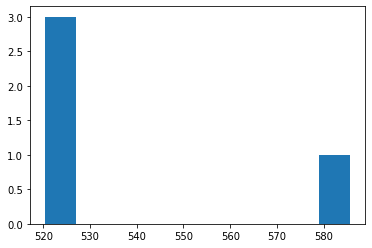

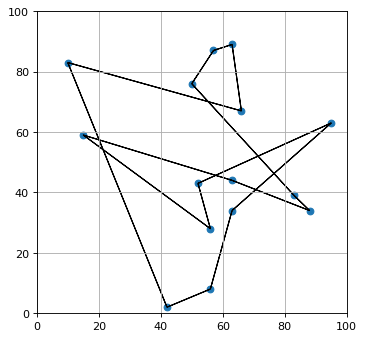

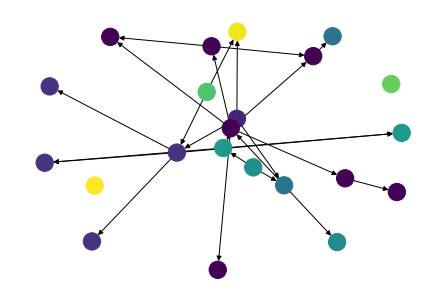

['gen', 'nevals', 'avg', 'std', 'min', 'max']
5  	4     	533.483	26.0562	520.455	585.595


In [ ]:
#@title Evolution  { run: "auto" }
population = 5 #@param {type:"slider", min:5, max:1000, step:5}
generations = 5 #@param {type:"slider", min:5, max:100, step:1}
crossover_rate = .7 #@param {type:"slider", min:0.1, max:1, step:0.1}
mutation_rate = .3 #@param {type:"slider", min:0.1, max:1, step:0.1}
delay_seconds = 1 #@param {type:"slider", min:1, max:10, step:1}

pop = toolbox.population(n=population)
history.update(pop)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

eaSimple(pop, toolbox, history, crossover_rate, mutation_rate, generations, stats=stats, halloffame=hof, delay = delay_seconds)